In [1]:
# Numerical/Stats pack
import numpy as np
from collections import Counter
import math
import numpy.linalg as nl
from cvxopt import matrix, solvers

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from qiskit.visualization import plot_histogram

In [2]:
def get_basis(num_qubits, index):
    """
    Parameters
    ----------
    num_qubits : int
        number of qubits.
    index : int
        Which qubit is 1. Order follows measurement order

    Returns
    -------
    base : int
        the basis string where target position is 1
        e.g., num_qubits=5, index=1, then return '01000'

    """
    origin = list('0'*num_qubits)
    origin[index] = '1'
    return ''.join(origin)
    
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def print_info(mat):
    u, s, vh = np.linalg.svd(mean_mat-ind_mat, full_matrices=True)
    ns = np.sum(s<1e-3)
    print("Rank={:.4g} # singular value < 1e-3={:.4g}".format(np.linalg.matrix_rank(mat),ns))
    print("Inf norm={:.4g}, Frobenius norm={:.4g}, 2-Norm={:.4g}".format(np.linalg.norm(mat, ord=np.inf), 
                                                                              np.linalg.norm(mat, ord='fro'),
                                                                              np.linalg.norm(mat, ord=2)))
    print("Among {:d} entries, {:d} entries < 1e-3, {:d} entries < 1e-4, {:d} entries < 1e-6".format(mat.shape[0]*mat.shape[1],
                                                                                                      mat[np.abs(mat)<1e-3].shape[0],
                                                                                                      mat[np.abs(mat)<1e-4].shape[0], 
                                                                                                      mat[np.abs(mat)<1e-6].shape[0]))
    
    
def extract_qubits(s, pos, correct_rest_bits):
    # Extract elements in given positions
    # E.g., s = '11010', pos = [0,2,3], correct_rest_bits = '10', the func returns 0, '101'
    # E.g., s = '11011', pos = [0,2,3], correct_rest_bits = '10', the func returns 1, '101'
    # E.g., s = '10011', pos = [0,2,3], correct_rest_bits = '10', the func returns 2, '101'
    # Because one of the unselected qubits (the last one) is different from correct_rest_bits
    res = []
    cor_count = 0
    total_num_qubits = len(pos)+len(correct_rest_bits)
    correct_rest_list = list(correct_rest_bits)
    for i in range(total_num_qubits):
        if i in pos:
            res.append(s[i])
        else:
            if s[i] != correct_rest_list.pop(0):
                cor_count += 1
    return cor_count, ''.join(res)

def recover_basis(target_basis, pos, rest_bits):
    # E.g., i = 3 (corresponds to '011'), pos = [0,2,3], rest_bits = '01'
    # func returns '0(0)11(1)'(no brackets) where two bits 0 and 1 in () corresponds to qubit 1 and 4
    total_num_qubits = len(pos)+len(rest_bits)
    selected_bits = list(target_basis)
    rest_bits_list = list(rest_bits)
    res = []
    for i in range(total_num_qubits):
        if i in pos:
            res.append(selected_bits.pop(0))
        else:
            res.append(rest_bits_list.pop(0))
    return ''.join(res)

    
def read_string_data(target_basis, selected_qubits, total_qubits, file_address, file_name=''):
    #target_basis corresponds to selected_qubits, instead of all qubits
    unselected_num_qubits = total_qubits - len(selected_qubits)
    if unselected_num_qubits == 0:
        if len(file_name) > 0:
            return np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
        return np.genfromtxt(file_address + 'Basis'+target_basis+'.csv', delimiter=',',dtype=np.str)
    else:
        orgin_data = np.array([],dtype=np.str)
        rest_bits = format(0, "0{:d}b".format(unselected_num_qubits)) # Only look at the case when the rest qubits are 0
        full_basis = recover_basis(target_basis, selected_qubits, rest_bits) # basis that length num_qubits 
                                                                  # where the selected indices corresponds to target_basis
        if len(file_name) > 0:
            orgin_data = np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
        else:
            orgin_data = np.genfromtxt(file_address + 'Basis'+full_basis+'.csv', delimiter=',',dtype=np.str)
        # Select out all uncorrelated bits
        selected_data = np.array([],dtype=np.str)
        unselected_data = np.array([],dtype=np.str)
        for s in orgin_data:
            corr_count, new_s = extract_qubits(s, selected_qubits, rest_bits)
            if corr_count == 0:
                selected_data = np.append(selected_data, new_s)
            else:
                unselected_data = np.append(unselected_data, new_s)
    return selected_data
    

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [4]:
# Choose machine
# file_address = "./QuitoData/" # Both machine has 5 qubits
file_address = "./LimaData/" # Both machine has 5 qubits
# file_address = './BelemData/'
total_qubits = 5
selected_qubits = [0,1,2,3,4] # Measurement order
num_qubits = len(selected_qubits)

In [5]:
# Full Matrix
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/string_data.shape[0]
    
np.savetxt(file_address+"Afull.txt", mean_mat)

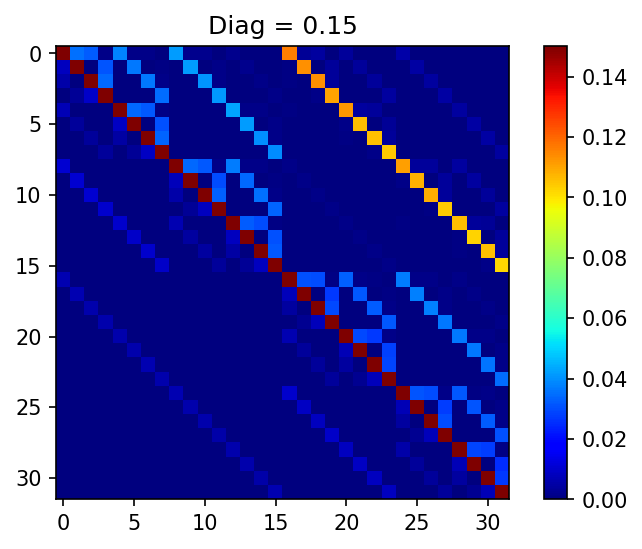

In [6]:
plt.rcParams["figure.dpi"] = 150
small_diag = np.copy(mean_mat)
for i in range(2**num_qubits):
    small_diag[i,i] = 0.15

plt.imshow(small_diag, cmap='jet')
plt.colorbar()
plt.title("Diag = 0.15")
plt.show()

# $$A_{full} = A_{ind} + A_{mask}$$
# $$ A_{mask} = A_{full} - A_{ind}$$

## where each entry in $A_{mask}$ ideally should close to 0.

# Method 0 Optimization

# Method 1

For example, if we have 5 qubits and we compute Pr(0|0) for Qubit 1, then we go to **data from circuit that constructs 00000** and have $$ Pr(0|0) =1 - \frac{m(01000)}{m(00000) + m(01000)}, $$ where $m()$ is the number of appearences of a given base in some dataset.

Similarly, if we compute Pr(1|1) for Qubit 1, then we go to **data from circuit that constructs 11111** and have $$ Pr(1|1) = 1 - \frac{m(10111)}{m(10111) + m(11111)}. $$

So we need 2 circuits.

In [7]:
ind_data0 = {} # Given 0
ind_data1 = {} # Given 1
for q in range(len(selected_qubits)):
    ind_data0[q] = np.array([], dtype = np.int)
    ind_data1[q] = np.array([], dtype = np.int)


p0m1_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 0 measure 1
p0m0_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors

string_data = read_string_data(('0'*num_qubits), selected_qubits, total_qubits, file_address)
for bits in string_data:
    if bits.count("1") == 0: # When all qubits are noise-free
        p0m0_total = p0m0_total + 1 
        for q in range(len(selected_qubits)):
            ind_data0[q] = np.append(ind_data0[q], 0)
    if bits.count("1") == 1:
        pos = bits.find('1') # Postion of the bit 1
        p0m1_count[pos] += 1
        p0m0_total[pos] += 1
        ind_data0[pos] = np.append(ind_data0[pos],1)

# Record probability of prepare 0 measure 0
p0m0 = (p0m0_total-p0m1_count)/p0m0_total


p1m0_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 1 measure 0
p1m1_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors

string_data = read_string_data(('1'*num_qubits), selected_qubits, total_qubits, file_address)
for bits in string_data:
    if bits.count("0") == 0: # When all qubits are noise-free
        p1m1_total = p1m1_total + 1 
        for q in range(len(selected_qubits)):
            ind_data1[q] = np.append(ind_data1[q], 1)
    if bits.count("0") == 1:
        pos = bits.find('0') # Postion of the bit 1
        p1m0_count[pos] += 1
        p1m1_total[pos] += 1
        ind_data1[pos] = np.append(ind_data1[pos],0)

# Record probability of prepare 1 measure 1
p1m1 = (p1m1_total-p1m0_count)/p1m1_total

# Method 2

For example, if we have 5 qubits and we compute Pr(0|0) for Qubit 1, then we go to **data from circuit that constructs 10111** and have $$ Pr(0|0) = \frac{m(10111)}{m(10111) + m(11111)}, $$ where $m()$ is the number of appearences of a given base in some dataset.

Similarly, if we compute Pr(1|1) for Qubit 1, then we go to **data from circuit that constructs 01000** and have $$ Pr(1|1) = \frac{m(01000)}{m(01000) + m(00000)}. $$

So we need $2n$ number of circuits where $n$ is the number of qubits. (~60000 measurements for 1 probability)

In [8]:
# p0m0 = np.zeros(num_qubits) # Record probability of prepare 0 measure 0
# p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


# for index in range(num_qubits):
#     # Read data
#     temp_string = get_basis(num_qubits, index)
#     target = ''.join('1' if s == '0' else '0' for s in temp_string) # Corresponding bit string
#     string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
# #     string_data = string_data[:int(string_data.shape[0]/4)]
#     # Record number of 1's when other qubits is noise-free
#     num_data = 0
#     num_0 = 0
#     for bits in string_data:
#         others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
#         if others == '1'*(num_qubits-1): # Make sure other qubits is noise-free
#             num_data += 1
#             if bits[index] == '0':
#                 num_0 += 1
                
#     # Record data
#     p0m0[index] = num_0/num_data
#     p0m0_total[index] = num_data
    
    
# p1m1 = np.zeros(num_qubits) # Record probability of prepare 1 measure 1
# p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


# for index in range(num_qubits):
#     # Read data
#     target = get_basis(num_qubits, index) # Corresponding bit string
#     string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
# #     string_data = string_data[:int(string_data.shape[0]/4)]
#     # Record number of 1's when other qubits is noise-free
#     num_data = 0
#     num_1 = 0
#     for bits in string_data:
#         others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
#         if others == '0'*(num_qubits-1): # Make sure other qubits is noise-free
#             num_data += 1
#             if bits[index] == '1':
#                 num_1 += 1
                
#     # Record data
#     p1m1[index] = num_1/num_data
#     p1m1_total[index] = num_data

# Method 3

Use all possible basis circuits

So we need $2^n$ number of circuits where $n$ is the number of qubits. (~900,000 measurements for 1 probability)

In [9]:
# p0m0_count = np.zeros(num_qubits) # Record counts of prepare 0 measure 0
# p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors
# p1m1_count = np.zeros(num_qubits) # Record counts of prepare 1 measure 1
# p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors

# # Go through all possibile basis datasets
# for bn in range(2**num_qubits):
#     target = format(bn, "0{:d}b".format(num_qubits))
#     string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
# #     string_data = string_data[:4000]
    
#     # Then for each data (bitstring) in the dataset
#     for meas_res in string_data:
#         meas_int = int(meas_res, 2) # to binary number
#         if meas_res == target: # If there is no error
#             for i in range(num_qubits):
#                 if int(target[i],2): # if bit is 1
#                     p1m1_count[i] += 1
#                     p1m1_total[i] += 1
#                 else:
#                     p0m0_count[i] += 1
#                     p0m0_total[i] += 1
        
#         if differAtOneBitPos(bn, meas_int): # if given basis and measured basis only differ by 1 bit
#             diff_pos = num_qubits - posOfRightMostDiffBit(bn, meas_int) - 1 # position that the bit is different
#             if target[diff_pos] == '0':
#                 p0m0_total[diff_pos] += 1
#             else:
#                 p1m1_total[diff_pos] += 1
            
# # Record probability of prepare 0 measure 0
# p0m0 = p0m0_count/p0m0_total
# # Record probability of prepare 1 measure 1
# p1m1 = p1m1_count/p1m1_total

In [10]:
std_erros0 = np.array([],dtype = np.float64)
std_erros1 = np.array([],dtype = np.float64)
for i in range(len(selected_qubits)):
    std_erros0 = np.append(std_erros0, np.std(ind_data0[i])/np.sqrt(p0m0_total[i]))
    std_erros1 = np.append(std_erros1, np.std(ind_data1[i])/np.sqrt(p1m1_total[i]))

for i in range(len(selected_qubits)):
    print("Qubit {:d}: sd(0|0)={:8.4g}, sd/sqrt(N)={:8.3e}| sd(1|1)={:8.4g}, sd/sqrt(N)={:8.3e}"
          .format(selected_qubits[i], 
                  np.std(ind_data0[i]),
                  np.std(ind_data0[i])/np.sqrt(p0m0_total[i]),
                  np.std(ind_data1[i]),
                  np.std(ind_data1[i])/np.sqrt(p1m1_total[i])))

Qubit 0: sd(0|0)= 0.08301, sd/sqrt(N)=3.297e-04| sd(1|1)=  0.3243, sd/sqrt(N)=1.369e-03
Qubit 1: sd(0|0)=  0.1042, sd/sqrt(N)=4.130e-04| sd(1|1)=  0.2049, sd/sqrt(N)=9.013e-04
Qubit 2: sd(0|0)= 0.08575, sd/sqrt(N)=3.405e-04| sd(1|1)=  0.1944, sd/sqrt(N)=8.572e-04
Qubit 3: sd(0|0)= 0.07466, sd/sqrt(N)=2.967e-04| sd(1|1)=  0.1782, sd/sqrt(N)=7.882e-04
Qubit 4: sd(0|0)= 0.09355, sd/sqrt(N)=3.712e-04| sd(1|1)=  0.1841, sd/sqrt(N)=8.135e-04


In [11]:
p0m0, p0m0_total, p1m1, p1m1_total

(array([0.99306092, 0.98902117, 0.99259131, 0.99439391, 0.99116953]),
 array([63409, 63668, 63439, 63324, 63530]),
 array([0.88056164, 0.95608265, 0.96065472, 0.96717878, 0.96487494]),
 array([56121, 51688, 51442, 51095, 51217]))

In [12]:
# Construct 5 matrices
c = 6 # multiplier
highest_single_mats = qubit_matrix(p0m0-c*std_erros0,p1m1-c*std_erros1)
lowest_single_mats = qubit_matrix(p0m0+c*std_erros0,p1m1+c*std_erros1)
single_qubit_mats = qubit_matrix(p0m0,p1m1)
single_qubit_mats

array([[[0.99306092, 0.11943836],
        [0.00693908, 0.88056164]],

       [[0.98902117, 0.04391735],
        [0.01097883, 0.95608265]],

       [[0.99259131, 0.03934528],
        [0.00740869, 0.96065472]],

       [[0.99439391, 0.03282122],
        [0.00560609, 0.96717878]],

       [[0.99116953, 0.03512506],
        [0.00883047, 0.96487494]]])

In [13]:
# matrix with independent assumption
ind_mat = single_qubit_mats[0]
hig_ind = highest_single_mats[0]
low_ind = lowest_single_mats[0]
for i in range(1,num_qubits):
    ind_mat = np.kron(ind_mat, single_qubit_mats[i])
    hig_ind = np.kron(hig_ind, highest_single_mats[i])
    low_ind = np.kron(low_ind, lowest_single_mats[i])

In [14]:
corr_coords = []
for i in range(2**num_qubits):
    for j in range(2**num_qubits):
        # Find left(lower bound) and right(upper bound)
        if low_ind[i,j] <= hig_ind[i,j]:
            left = low_ind[i,j]
            right = hig_ind[i,j]
        else:
            left = hig_ind[i,j]
            right = low_ind[i,j]
        # See if each entry is in the range
        if mean_mat[i,j] > right or mean_mat[i,j] < left: # If below lower bound or above the upperbound
            corr_coords.append((i,j))
            print("({:2d},{:2d}) {:12.4g},{:12.4g},{:12.4g}".format(i,j, left, mean_mat[i,j], right))

( 0,10)     0.001064,    0.001907,    0.001798
( 0,13)    3.949e-05,   0.0001678,   8.636e-05
( 0,15)    1.113e-06,           0,   3.267e-06
( 0,23)    3.205e-06,   1.526e-05,   8.416e-06
( 0,27)     3.62e-06,           0,   9.369e-06
( 0,28)     0.000145,   0.0001068,    0.000275
( 0,29)    4.414e-06,   1.526e-05,   1.112e-05
( 0,30)    4.088e-06,   4.578e-05,    1.04e-05
( 0,31)    1.245e-07,           0,   4.208e-07
( 1, 6)    6.259e-06,   4.578e-05,   1.806e-05
( 1,10)     7.07e-06,   3.052e-05,   2.011e-05
( 1,12)    8.621e-06,           0,   2.387e-05
( 1,14)    2.431e-07,           0,    9.03e-07
( 1,18)    2.035e-05,   6.104e-05,    5.18e-05
( 1,20)    2.481e-05,   1.526e-05,   6.149e-05
( 1,21)     0.003644,     0.00354,    0.005339
( 1,22)    6.997e-07,           0,   2.326e-06
( 1,24)    2.802e-05,   1.526e-05,   6.846e-05
( 1,26)    7.903e-07,           0,    2.59e-06
( 1,27)    0.0001161,   0.0001068,   0.0002248
( 1,28)    9.637e-07,           0,   3.075e-06
( 1,30)    2.

In [15]:
# # Optimized Matrix
# opt_params = np.genfromtxt(file_address + 'Aopt.txt', delimiter=',',dtype=np.float64)
# opt_p0m0 = opt_params[0:num_qubits]
# opt_p1m1 = opt_params[num_qubits:2*num_qubits]
# single_opt_mats = qubit_matrix(opt_p0m0,opt_p1m1)

# opt_mat = single_opt_mats[0]
# for i in range(1,num_qubits):
#     opt_mat = np.kron(opt_mat, single_opt_mats[i])

In [16]:
print("A_full - A_ind")
print_info(mean_mat - ind_mat)
# print("A_full - A_opt")
# print_info(mean_mat - opt_mat)

A_full - A_ind
Rank=31 # singular value < 1e-3=9
Inf norm=0.01284, Frobenius norm=0.01941, 2-Norm=0.007467
Among 1024 entries, 949 entries < 1e-3, 757 entries < 1e-4, 209 entries < 1e-6


In [17]:
# u, s, vh = np.linalg.svd(mean_mat - opt_mat, full_matrices=True)
# s

In [18]:
# Check singular values
u, s, vh = np.linalg.svd(mean_mat-ind_mat, full_matrices=True)
s

array([7.46745056e-03, 6.41722939e-03, 5.86533144e-03, 5.62415472e-03,
       5.28394029e-03, 4.85409227e-03, 4.54221844e-03, 4.36092178e-03,
       4.27301177e-03, 4.02629607e-03, 3.72381339e-03, 3.63370899e-03,
       3.35730802e-03, 3.06613407e-03, 3.03201664e-03, 2.75363209e-03,
       2.35220983e-03, 2.13779677e-03, 1.90381369e-03, 1.74817021e-03,
       1.37747459e-03, 1.29148669e-03, 1.03049146e-03, 9.53594023e-04,
       7.15089834e-04, 6.43055368e-04, 5.04890290e-04, 3.38093087e-04,
       2.33288554e-04, 1.06039402e-04, 1.84481065e-05, 2.25437686e-18])

Rank=31 # singular value < 1e-3=9
Inf norm=0.01284, Frobenius norm=0.01941, 2-Norm=0.007467
Among 1024 entries, 949 entries < 1e-3, 757 entries < 1e-4, 209 entries < 1e-6


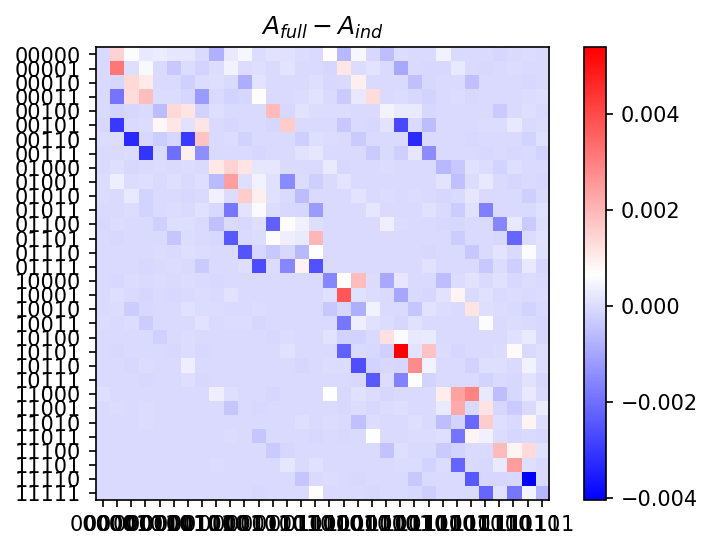

In [19]:
# plt.rcParams["figure.figsize"] = (10, 11)
plt.rcParams["figure.dpi"] = 150

# Differences
diff_mat = mean_mat - ind_mat
print_info(diff_mat)

# for i in range(2**num_qubits):
#     diff_mat[i,i] = 0

plt.imshow(diff_mat, cmap='bwr')
plt.colorbar()
plt.title("$A_{full} - A_{ind}$")
plt.xticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.yticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.show()

Rank=32 # singular value < 1e-3=9
Inf norm=0.01284, Frobenius norm=0.01941, 2-Norm=0.008582
Among 1024 entries, 949 entries < 1e-3, 757 entries < 1e-4, 209 entries < 1e-6


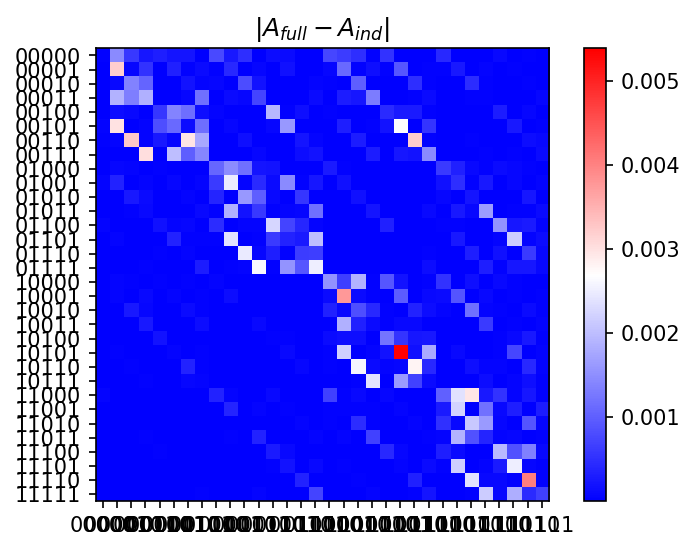

In [20]:
# Differences
diff_mat = np.abs(mean_mat - ind_mat)
print_info(diff_mat)

# for i in range(2**num_qubits):
#     diff_mat[i,i] = 0

plt.imshow(diff_mat, cmap='bwr')
plt.colorbar()
plt.title("$|A_{full} - A_{ind}|$")
plt.xticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.yticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.show()

Rank=32 # singular value < 1e-3=9
Inf norm=0.005839, Frobenius norm=0.01048, 2-Norm=0.003726
Among 1024 entries, 1004 entries < 1e-3, 967 entries < 1e-4, 680 entries < 1e-6


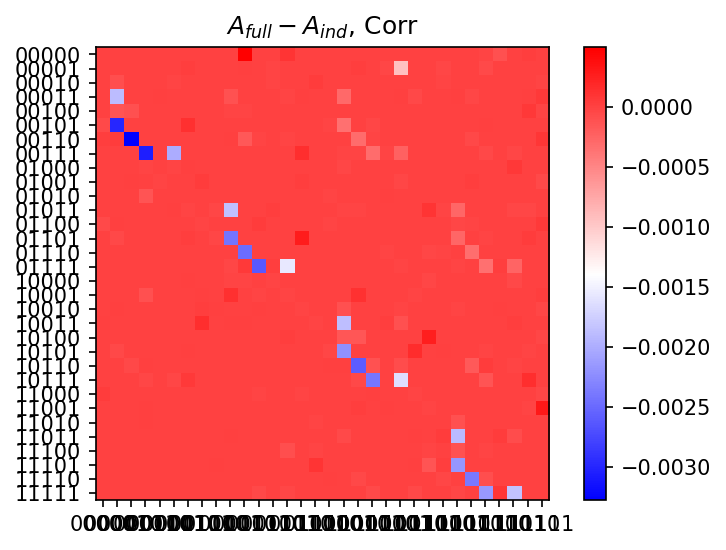

In [21]:
# Differences
diff_mat = mean_mat - ind_mat
for i in range(2**num_qubits):
    for j in range(2**num_qubits):
        if (i,j) not in corr_coords:
            diff_mat[i,j] = 0
print_info(diff_mat)

plt.imshow(diff_mat, cmap='bwr', )
plt.colorbar()
plt.title("$A_{full} - A_{ind}$, Corr")
plt.xticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.yticks(np.arange(0,2**num_qubits,1), [format(bn, "0{:d}b".format(num_qubits)) for bn in np.arange(0,2**num_qubits,1)])
plt.show()

In [28]:
adj_p0m0 = np.copy(p0m0)
adj_p1m1 = np.copy(p1m1)


# Adjust for 0,1,2,3,4, RESULT FROM ABOVE
adj_p0m0[1] = adj_p0m0[1]-0.001
adj_p0m0[2] = adj_p0m0[2]+0.0036
adj_p0m0[3] = adj_p0m0[3]+0.0021
adj_p0m0[4] = adj_p0m0[4]-0.0011

adj_p1m1[0] = adj_p1m1[0]+0.003


adjusted_mats = qubit_matrix(adj_p0m0,adj_p1m1)

# matrix with independent assumption
adj_mat = adjusted_mats[0]
for i in range(1,num_qubits):
    adj_mat = np.kron(adj_mat, adjusted_mats[i])

In [29]:
# print_info(mean_mat - opt_mat)
# plt.imshow(mean_mat - opt_mat, cmap='jet')
# plt.colorbar()
# plt.title("$A_{full} - A_{ind}^{opt}$")
# plt.show()

In [30]:
# Check singular values
u, s, vh = np.linalg.svd(mean_mat -  ind_mat, full_matrices=True)
s

array([7.46745056e-03, 6.41722939e-03, 5.86533144e-03, 5.62415472e-03,
       5.28394029e-03, 4.85409227e-03, 4.54221844e-03, 4.36092178e-03,
       4.27301177e-03, 4.02629607e-03, 3.72381339e-03, 3.63370899e-03,
       3.35730802e-03, 3.06613407e-03, 3.03201664e-03, 2.75363209e-03,
       2.35220983e-03, 2.13779677e-03, 1.90381369e-03, 1.74817021e-03,
       1.37747459e-03, 1.29148669e-03, 1.03049146e-03, 9.53594023e-04,
       7.15089834e-04, 6.43055368e-04, 5.04890290e-04, 3.38093087e-04,
       2.33288554e-04, 1.06039402e-04, 1.84481065e-05, 2.25437686e-18])

In [31]:
# Choose largest several components 
num_comp = num_qubits
red_diff = np.dot(np.dot(u[:,0:num_comp],np.diag(s[0:num_comp])),vh[0:num_comp])
red_mat = ind_mat + red_diff
print_info(mean_mat -  red_mat)

print_info(mean_mat -  ind_mat)

Rank=26 # singular value < 1e-3=9
Inf norm=0.01183, Frobenius norm=0.01363, 2-Norm=0.004854
Among 1024 entries, 977 entries < 1e-3, 548 entries < 1e-4, 6 entries < 1e-6
Rank=31 # singular value < 1e-3=9
Inf norm=0.01284, Frobenius norm=0.01941, 2-Norm=0.007467
Among 1024 entries, 949 entries < 1e-3, 757 entries < 1e-4, 209 entries < 1e-6


In [32]:
def find_least_norm(nQubits, ptilde):
    # Formulation
    Q = 2 * matrix(np.identity(2**nQubits))
    p = -2 * matrix(ptilde)

    G = -matrix(np.identity(2**nQubits))
    h = matrix(np.zeros(2**nQubits))

    A = matrix(np.ones(2**nQubits), (1, 2**nQubits))
    b = matrix(1.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h, A, b)
    return sol['status'], sol['x']


# def dictToVec(nQubits, counts):
#     vec = np.zeros(2**nQubits)
#     form = "{0:0" + str(nQubits) + "b}"
#     for i in range(2**nQubits):
#         key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
#                              # and delete variable form
#         if key in counts.keys():
#             vec[i] = int(counts[key])
#         else:
#             vec[i] = 0
#     return vec


def vecToDict(nQubits, shots, vec):
    counts = {}
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i)
        counts[key] = int(vec[i] * shots)
    return counts

def meas_dist(true_probs, real_counts):
    total_counts = sum(real_counts.values())
    counts_off = 0
    for key in real_counts:
        counts_off += np.abs(real_counts[key] - true_probs[int(key,2)]*total_counts)
        
    return 0.5*counts_off/total_counts

Qubit 4
Given Lambdas [0.9176 0.9482]


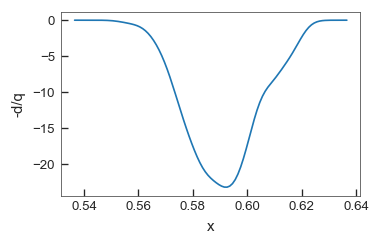

Final Accepted Posterior Lambdas
M: 23.2294 Maximizer: 0.592163 pi_obs = 26.3108 pi_Q(prior) = 1.13265
Progress: 99.998%
Accepted Number N: 2125, fraction 0.043
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94989965 0.77779533]
Posterior Lambda Mode [0.98405197 0.7965616 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00405603
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


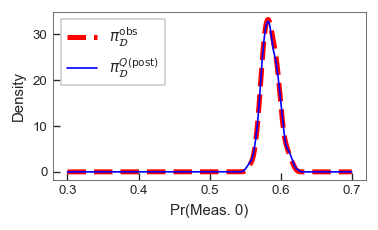

Qubit 3
Given Lambdas [0.953  0.9685]


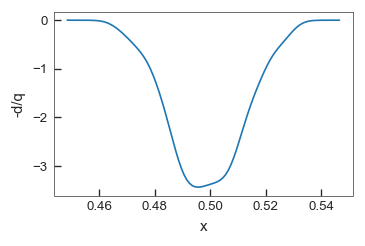

Final Accepted Posterior Lambdas
M: 3.43463 Maximizer: 0.495555 pi_obs = 30.6889 pi_Q(prior) = 8.93514
Progress: 99.998%
Accepted Number N: 14615, fraction 0.292
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.92023092 0.92234891]
Posterior Lambda Mode [0.94452057 0.9532571 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00078054
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


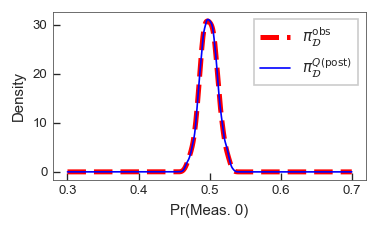

Qubit 2
Given Lambdas [0.9648 0.9785]


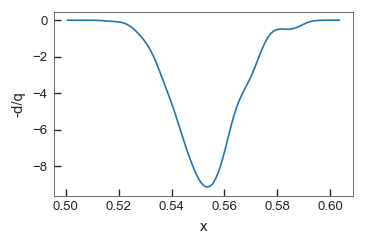

Final Accepted Posterior Lambdas
M: 9.13804 Maximizer: 0.553576 pi_obs = 34.4969 pi_Q(prior) = 3.77509
Progress: 99.998%
Accepted Number N: 5415, fraction 0.108
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.95026723 0.84851468]
Posterior Lambda Mode [0.98443735 0.86409311]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00134647
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


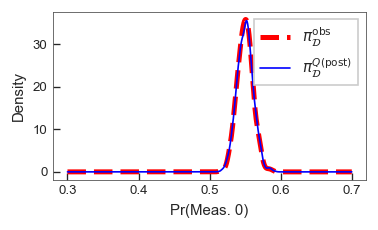

Qubit 1
Given Lambdas [0.974  0.9846]


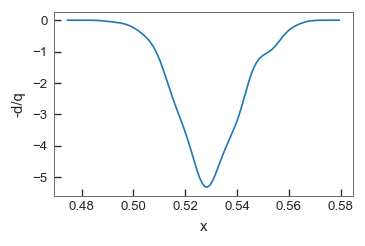

Final Accepted Posterior Lambdas
M: 5.32941 Maximizer: 0.528293 pi_obs = 36.7236 pi_Q(prior) = 6.89074
Progress: 99.998%
Accepted Number N: 9323, fraction 0.186
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94496384 0.8917161 ]
Posterior Lambda Mode [0.98466545 0.90944106]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000737526
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


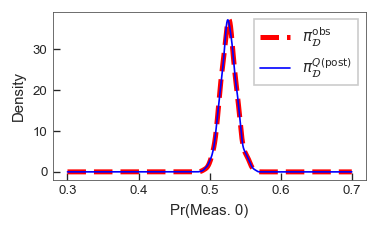

Qubit 0
Given Lambdas [0.9656 0.9763]


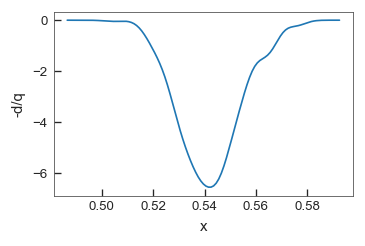

Final Accepted Posterior Lambdas
M: 6.56041 Maximizer: 0.54203 pi_obs = 33.7745 pi_Q(prior) = 5.14822
Progress: 99.998%
Accepted Number N: 7667, fraction 0.153
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94603891 0.86756521]
Posterior Lambda Mode [0.98502354 0.89225512]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0015748
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


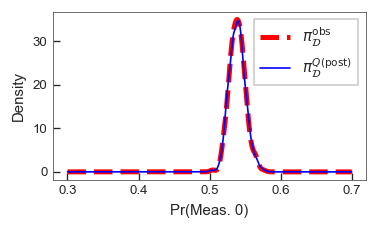

In [36]:
import measfilter as mf
ind_filter = mf.MeasFilter(selected_qubits[::-1], file_address=file_address)
ind_filter.inference(nPrior = 50000, seed=14687,show_denoised=False,shots_per_point=2048)

In [37]:
# print_info(mean_mat-ind_filter.mat_mean)
# plt.imshow(mean_mat-ind_filter.mat_mean, cmap='jet')
# plt.colorbar()
# plt.title("$A_{Full} - A_{CB}$")
# plt.xticks(range(2**num_qubits))
# plt.yticks(range(2**num_qubits))
# plt.show()

In [43]:
cb_means = ind_filter.mean()
cb_means

{'Qubit4': array([0.94989965, 0.77779533]),
 'Qubit3': array([0.92023092, 0.92234891]),
 'Qubit2': array([0.95026723, 0.84851468]),
 'Qubit1': array([0.94496384, 0.8917161 ]),
 'Qubit0': array([0.94603891, 0.86756521])}

In [48]:
cb_p0m0 = np.zeros(5,dtype=np.float64)
cb_p1m1 = np.zeros(5,dtype=np.float64)
for key,value in cb_means.items():
    pos = num_qubits - int(key[-1])-1
    cb_p0m0[pos] = value[0]
    cb_p1m1[pos] = value[1]
    
cb_p0m0[1] = cb_p0m0[1]-0.001
cb_p0m0[2] = cb_p0m0[2]+0.0036
cb_p0m0[3] = cb_p0m0[3]+0.0021
cb_p0m0[4] = cb_p0m0[4]-0.0011
cb_p1m1[0] = cb_p1m1[0]+0.003

cb_adjusted_mats = qubit_matrix(cb_p0m0,cb_p1m1)

# matrix with independent assumption
cb_adj_mat = cb_adjusted_mats[0]
for i in range(1,num_qubits):
    cb_adj_mat = np.kron(cb_adj_mat, cb_adjusted_mats[i])

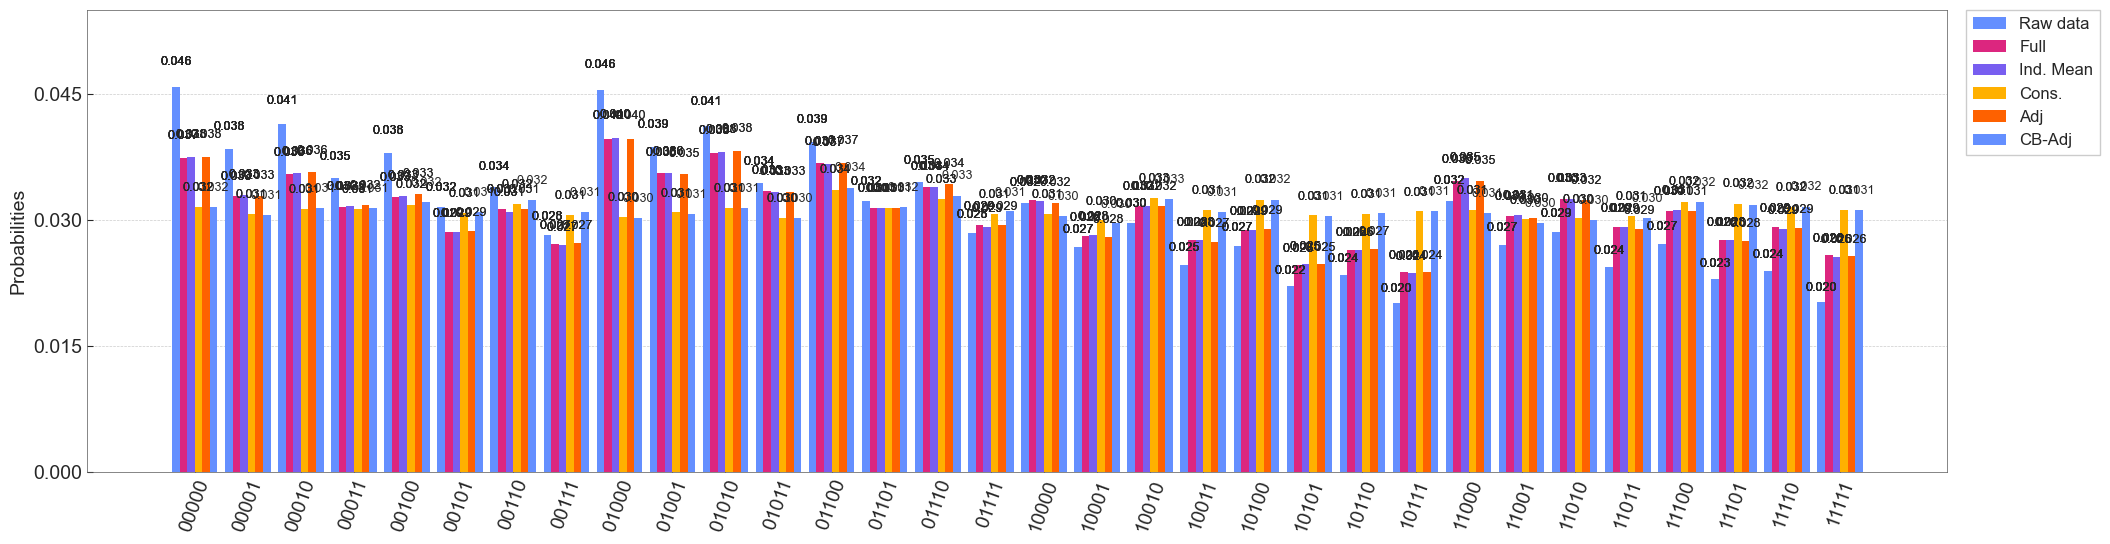

In [49]:
shots = 8192
had_strings = read_string_data(('0'*num_qubits), selected_qubits, total_qubits, file_address, file_name='Had.csv')
real_counts = Counter(had_strings)
real_vec = dictToVec(total_qubits,real_counts)/(shots*64)

full_status, full_vec = find_least_norm(num_qubits, nl.solve(mean_mat, real_vec))
full_counts = vecToDict(total_qubits, shots*64, full_vec)

ind_status, ind_vec = find_least_norm(num_qubits, nl.solve(ind_mat, real_vec))
ind_counts = vecToDict(total_qubits, shots*64, ind_vec)

adj_status, adj_vec = find_least_norm(num_qubits, nl.solve(adj_mat, real_vec))
adj_counts = vecToDict(total_qubits, shots*64, adj_vec)

# red_status, red_vec = find_least_norm(num_qubits, nl.solve(red_mat, real_vec))
# red_counts = vecToDict(total_qubits, shots*64, red_vec)

con_counts = ind_filter.filter_mean(real_counts)

cb_adj_status, cb_adj_vec = find_least_norm(num_qubits, nl.solve(cb_adj_mat, real_vec))
cb_adj_counts = vecToDict(total_qubits, shots*64, cb_adj_vec)

# opt_status, opt_vec = find_least_norm(num_qubits, nl.solve(opt_mat, real_vec))
# opt_counts = vecToDict(total_qubits, shots*64, opt_vec)

# legend = ["Raw data", "Full",  "Ind. Mean", "Reduced", "Opt"]
# plot_histogram([real_counts, full_counts, ind_counts, red_counts, opt_counts], legend=legend,  figsize=(24, 6))
legend = ["Raw data", "Full",  "Ind. Mean", "Cons.", "Adj", "CB-Adj"]
plot_histogram([real_counts, full_counts, ind_counts, con_counts, adj_counts, cb_adj_counts], legend=legend,  figsize=(24, 6))

In [50]:
had_probs = [1/2**total_qubits]*(2**total_qubits)
print("Raw: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, real_counts)))
print("Full A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, full_counts)))
print("Ind. Mean: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, ind_counts)))
# print("Opt. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, opt_counts)))
print("Cons. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, con_counts)))
# print("Red. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, red_counts)))
print("Adj. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, adj_counts)))
print("CB-Adj. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, cb_adj_counts)))

Raw: total probalities dist from true = 0.0949574
Full A: total probalities dist from true = 0.0507017
Ind. Mean: total probalities dist from true = 0.0513245
Cons. A: total probalities dist from true = 0.0103012
Adj. A: total probalities dist from true = 0.051272
CB-Adj. A: total probalities dist from true = 0.0116808
